In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
path="/content/drive/MyDrive/skin_data"
images_folder_path=os.path.join(path,"train_data")
masks_folder_path=os.path.join(path,"train_label")

In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
image_size=(224,224)
class SegmentationDataset(Dataset):
    def __init__(self, images_folder, masks_folder, image_files, mask_files, image_transform=None, mask_transform=None):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.image_files = image_files
        self.mask_files = mask_files
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_folder, self.image_files[idx])
        mask_path = os.path.join(self.masks_folder, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB").resize(image_size)
        mask = Image.open(mask_path).convert("L").resize(image_size)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask




In [5]:
image_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

In [6]:


# Get a list of all image and mask files
image_files = sorted(os.listdir(images_folder_path))
mask_files = sorted(os.listdir(masks_folder_path))

# Split the data into train and test sets
image_train, image_test, mask_train, mask_test = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)


In [7]:
# Create training and testing datasets
train_dataset = SegmentationDataset(images_folder_path, masks_folder_path, image_train, mask_train,image_transform=image_transform,mask_transform=mask_transform)
test_dataset = SegmentationDataset(images_folder_path, masks_folder_path, image_test, mask_test,image_transform=image_transform,mask_transform=mask_transform)

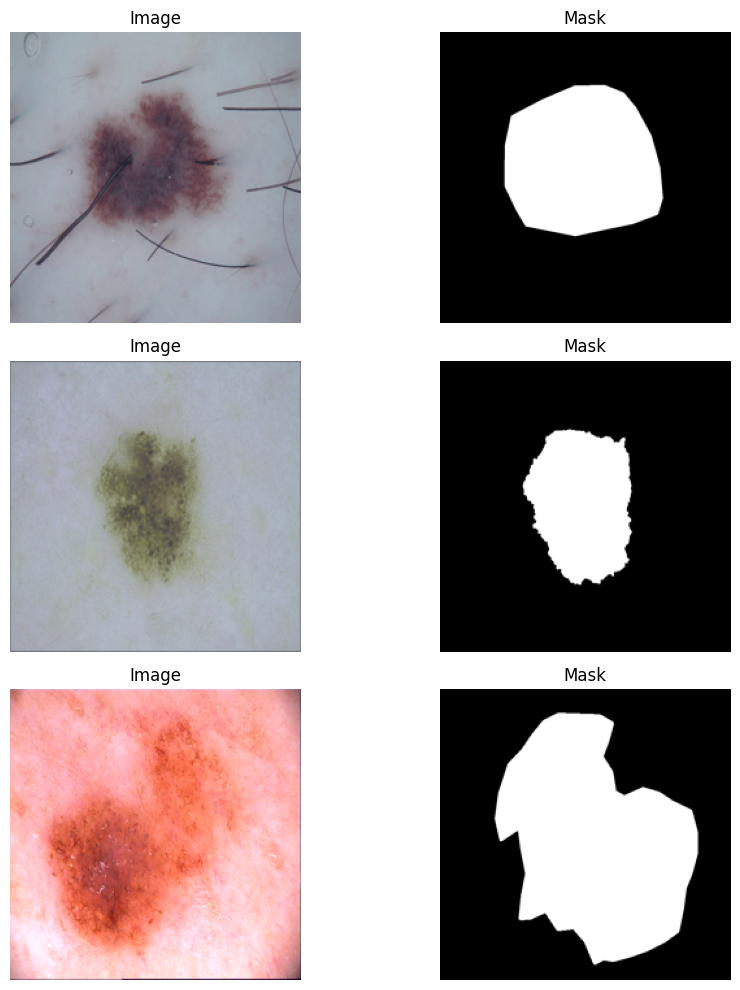

In [8]:
import matplotlib.pyplot as plt

# Define the number of images to display
num_images_to_display = 3

# Create subplots for displaying images and masks
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(10, 10))

for i in range(num_images_to_display):
    # Get a random index from the dataset
    random_index = torch.randint(len(train_dataset), size=(1,)).item()

    # Fetch an image and its mask from the dataset
    image, mask = train_dataset[random_index]

    # Display the image
    axes[i, 0].imshow((image.permute(1, 2, 0) * 0.229 + 0.485).clamp(0, 1))
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    # Display the mask using a grayscale colormap
    axes[i, 1].imshow(mask.squeeze(), cmap='gray')
    axes[i, 1].set_title('Mask')
    axes[i, 1].axis('off')


# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [9]:
from torch.utils.data import DataLoader

batch_size = 8  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
for images, masks in train_loader:
    print("Target images Shape:", images.shape)
    print("Target Mask Shape:", masks.shape)
    break
    # Rest of your training code here

Target images Shape: torch.Size([8, 3, 224, 224])
Target Mask Shape: torch.Size([8, 1, 224, 224])


In [11]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=f941dc03e03bc6254a1a664792164415b40164a9218f8a22e4e2a458bb50ebaf
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=2568ad61d010342bd87e6a29372b71ed14e319bdfb36adfe23a30a1ad75a2b1a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [12]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from segmentation_models_pytorch import Unet
import segmentation_models_pytorch as smp

In [13]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 7.6 MB/s eta 0:00:00


In [14]:
model = smp.Unet(encoder_name="mit_b0", in_channels=3, classes=1)  # Customize as needed
#loss_function = torch.nn.CrossEntropyLoss()  # Use appropriate loss for your task
from torch.nn.functional import binary_cross_entropy_with_logits

def dice_loss(logits, targets):
    smooth = 1e-5
    logits = torch.sigmoid(logits)
    intersection = (logits * targets).sum()
    union = logits.sum() + targets.sum() + smooth
    dice = (2 * intersection + smooth) / union
    return 1 - dice

loss_function = dice_loss

# loss_function = torch.nn.BCEWithLogitsLoss()  # Use appropriate loss for your task
optimizer = torch.optim.Adam(model.parameters(), lr=0.00006)  # Customize optimizer and learning rate

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# optimizer = SAM(model.parameters(), base_optimizer, rho=0.05)

Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b0.pth" to /root/.cache/torch/hub/checkpoints/mit_b0.pth
100%|██████████| 13.7M/13.7M [00:01<00:00, 12.6MB/s]


Unet(
  (encoder): MixVisionTransformerEncoder(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=32, o

In [17]:
import segmentation_models_pytorch as smp
import torch
import torch.nn.functional as F

# Define your model using smp.Unet
model = smp.Unet(encoder_name="mit_b0", in_channels=3, classes=1)
num_epochs = 10

# Define the Dice loss function
def dice_loss(logits, targets):
    smooth = 1e-5
    logits = torch.sigmoid(logits)
    intersection = (logits * targets).sum()
    union = logits.sum() + targets.sum() + smooth
    dice = (2 * intersection + smooth) / union
    return 1 - dice

def iou_score(pred, target):
    smooth = 1e-5
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection + smooth
    iou = (intersection + smooth) / union
    return iou

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00006)

# Lists to store loss, IOU, and dice values
train_losses = []
train_ious = []
train_dices = []
val_losses = []
val_ious = []
val_dices = []

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_iou = 0.0  # Initialize epoch IOU
    epoch_dice = 0.0  # Initialize epoch Dice score

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = dice_loss(output, target)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate IOU for each batch and accumulate
        pred = torch.sigmoid(output) > 0.5
        iou = iou_score(pred, target)
        dice = 1 - loss.item()  # Dice coefficient is 1 - dice_loss
        epoch_iou += iou.item()
        epoch_dice += dice

    # Calculate and store training loss, IOU, and Dice score
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    avg_train_iou = epoch_iou / len(train_loader)
    train_ious.append(avg_train_iou)
    avg_train_dice = epoch_dice / len(train_loader)
    train_dices.append(avg_train_dice)

    # Evaluation loop
    model.eval()
    iou_total = 0.0
    dice_total = 0.0
    val_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for data, target in test_loader:  # Assuming you have validation data
            data, target = data.to(device), target.to(device)

            output = model(data)
            pred = torch.sigmoid(output) > 0.5

            iou = iou_score(pred, target)
            dice = 1 - dice_loss(output, target)
            iou_total += iou.item()
            dice_total += dice

            loss = dice_loss(output, target)
            val_loss += loss.item()

            num_samples += 1

    val_iou = iou_total / num_samples
    val_dice = dice_total / num_samples
    val_losses.append(val_loss / len(test_loader))
    val_ious.append(val_iou)
    val_dices.append(val_dice)

    # Print the results for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train IOU: {avg_train_iou:.4f}, Train Dice: {avg_train_dice:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val IOU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")


Epoch [1/10] - Train Loss: 0.4805, Train IOU: 0.5598, Train Dice: 0.5195, Val Loss: 8.7436, Val IOU: 0.6710, Val Dice: 0.6198
Epoch [2/10] - Train Loss: 0.3477, Train IOU: 0.6915, Train Dice: 0.6523, Val Loss: 7.4493, Val IOU: 0.6935, Val Dice: 0.6761
Epoch [3/10] - Train Loss: 0.2978, Train IOU: 0.7077, Train Dice: 0.7022, Val Loss: 6.8642, Val IOU: 0.6587, Val Dice: 0.7016
Epoch [4/10] - Train Loss: 0.2613, Train IOU: 0.7269, Train Dice: 0.7387, Val Loss: 5.8509, Val IOU: 0.7089, Val Dice: 0.7456
Epoch [5/10] - Train Loss: 0.2300, Train IOU: 0.7386, Train Dice: 0.7700, Val Loss: 5.2173, Val IOU: 0.7314, Val Dice: 0.7732
Epoch [6/10] - Train Loss: 0.2115, Train IOU: 0.7417, Train Dice: 0.7885, Val Loss: 4.7534, Val IOU: 0.7361, Val Dice: 0.7933
Epoch [7/10] - Train Loss: 0.1983, Train IOU: 0.7464, Train Dice: 0.8017, Val Loss: 4.8519, Val IOU: 0.7163, Val Dice: 0.7890
Epoch [8/10] - Train Loss: 0.1870, Train IOU: 0.7503, Train Dice: 0.8130, Val Loss: 4.1372, Val IOU: 0.7517, Val Dice:

In [24]:
val_dic = [item.item() for item in val_dices]

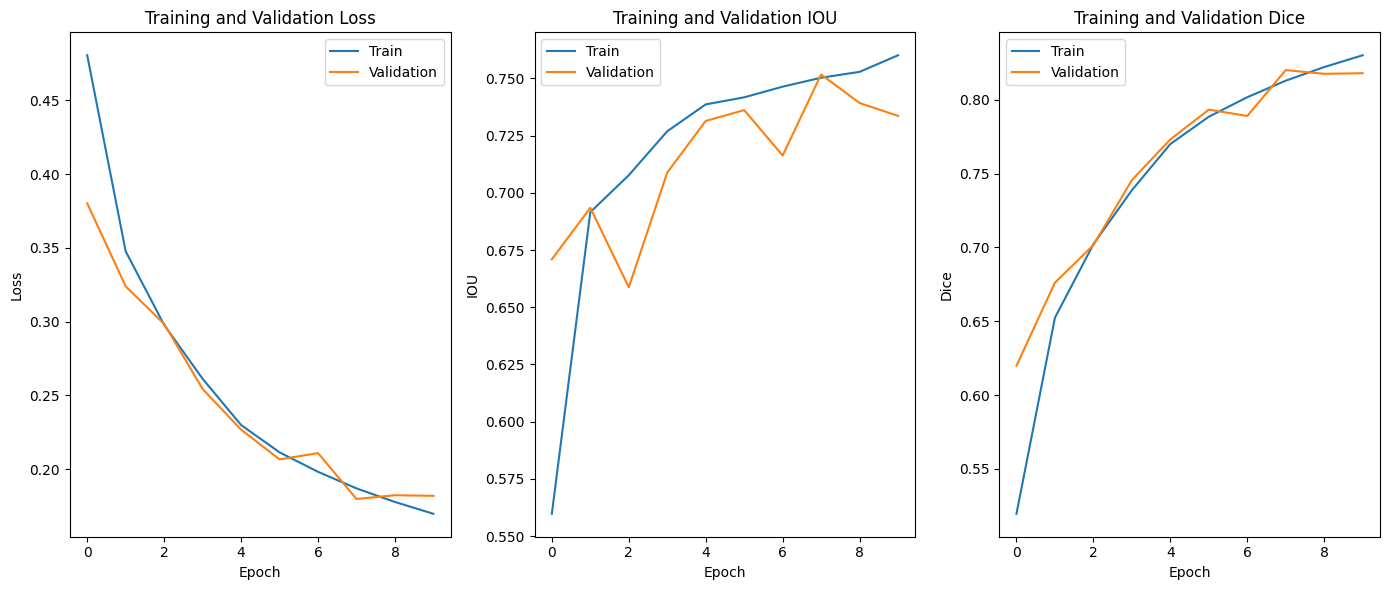

In [31]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation IOU
plt.subplot(1, 3, 2)
plt.plot(train_ious, label='Train')
plt.plot(val_ious, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('IOU')
plt.title('Training and Validation IOU')
plt.legend()

# Plot training and validation Dice
plt.subplot(1, 3, 3)
plt.plot(train_dices, label='Train')
plt.plot(val_dic, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Training and Validation Dice')
plt.legend()

plt.tight_layout()
plt.show()


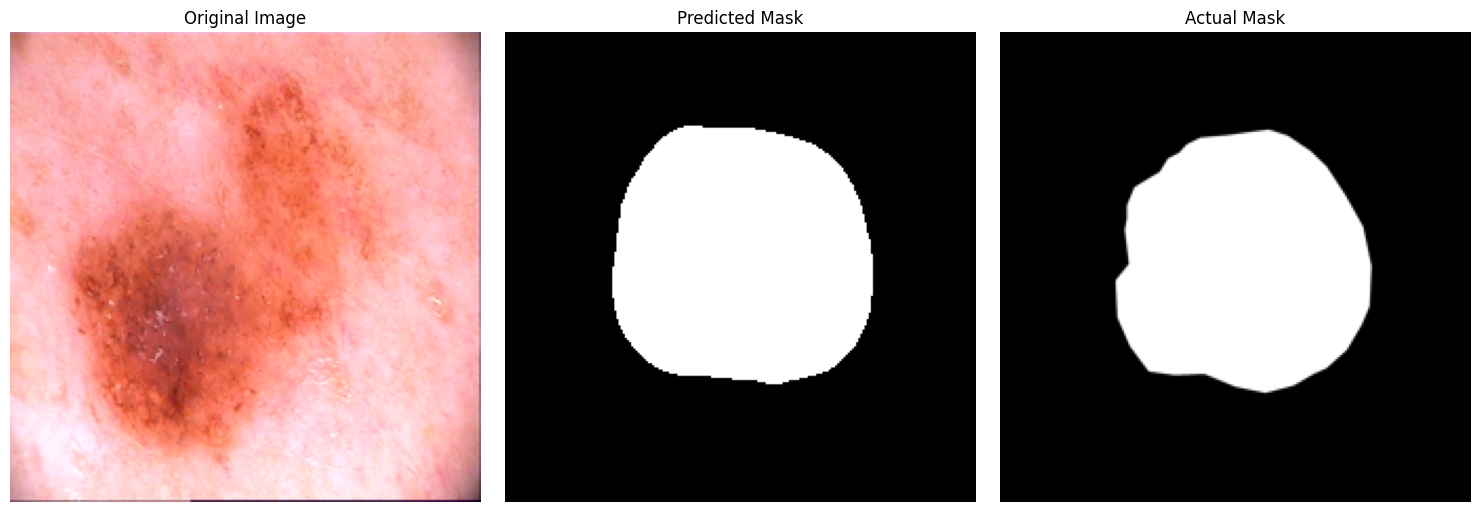

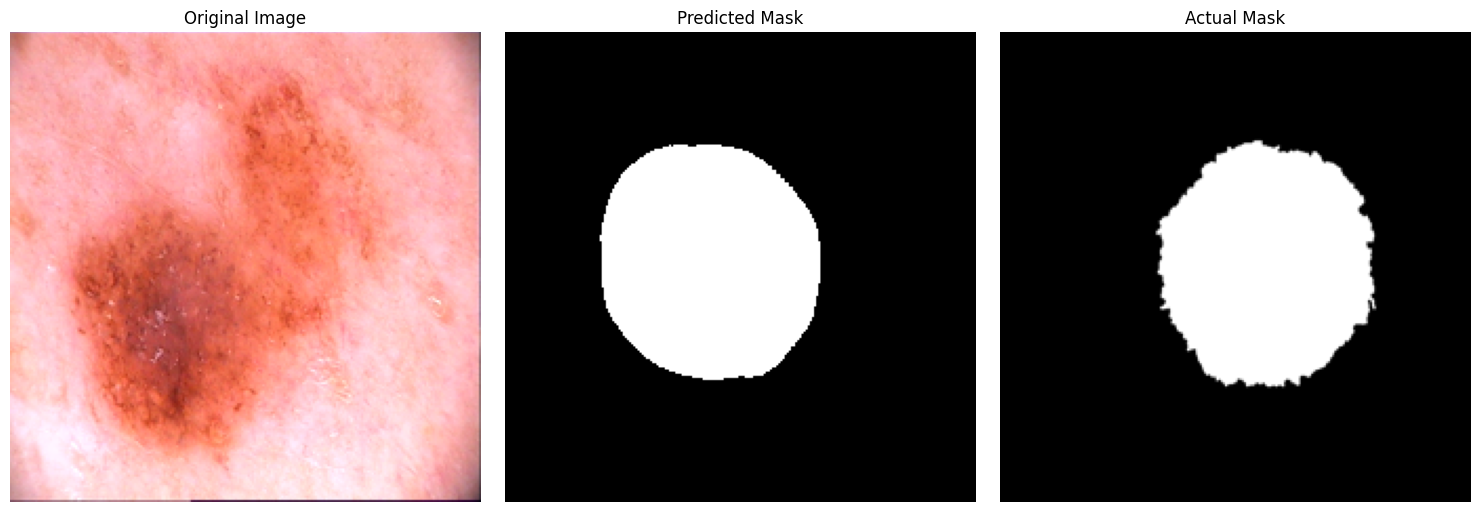

In [32]:
import matplotlib.pyplot as plt

# Change this to the number of samples you want to visualize
num_samples = 2

for batch_idx, (images, masks) in enumerate(test_loader):
    if batch_idx >= num_samples:
        break
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    predicted_masks = torch.sigmoid(outputs) > 0.5  # Convert predicted logits to binary mask

    for i in range(images.size(0)):
        plt.figure(figsize=(15, 10))
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow((image.permute(1, 2, 0) * 0.229 + 0.485).clamp(0, 1))
        plt.title("Original Image")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        predicted_mask = predicted_masks[i].squeeze(dim=1)
        plt.imshow(predicted_mask[i].cpu(),cmap='gray')  # Normalize mask to [0, 1]
        plt.title("Predicted Mask")
        plt.axis('off')

        # Actual Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(masks[i][0].cpu(), cmap='gray', vmin=0, vmax=1)  # Normalize mask to [0, 1]
        plt.title("Actual Mask")
        plt.axis('off')
        break

    plt.tight_layout()
    plt.show()


In [33]:
# Save your trained model
torch.save(model.state_dict(), "/content/drive/MyDrive/skin_data/trans_segment.pth")